In [1]:
#Importing necessary python libraries
import sqlite3
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.linear_model  import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, fbeta_score, make_scorer
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
%matplotlib inline

In [2]:
# connect to SQlite NHANES DB and read in necessary data.
con = sqlite3.connect("../data/NHANES SQLite DBs/2013-2014 NHANES Survey.db")
query = """

SELECT

SEQN, RIDAGEYR, RIAGENDR, BMXHT, BMXWT, BMXBMI, RIDRETH1, BPXDI1, 
BPXDI2, BPXDI3, BPXDI4, BPXSY1, BPXSY2, BPXSY3, BPXSY4, BPXCHR,
BPXPLS, BPXPULS, LBDHDD, LBDLDL, LBXTC, LBXTR, LBXSGL,
MCQ300a, PAD680, SMQ040,SMQ020, DIQ010, MCQ160e, MCQ160c

FROM demographic
JOIN examination
    USING(SEQN)
JOIN labs
    USING(SEQN)
JOIN questionnaire
    USING(SEQN)
;
"""
cad_df = pd.read_sql(query, con)

#Close SQLite DB connections
con.close()

#View DataFrame
cad_df.head()

,SEQN,RIDAGEYR,RIAGENDR,BMXHT,BMXWT,BMXBMI,RIDRETH1,BPXDI1,BPXDI2,BPXDI3,...,LBXTC,LBXTR,LBXSGL,MCQ300A,PAD680,SMQ040,SMQ020,DIQ010,MCQ160E,MCQ160C
0,73557,69,1,171.3,78.3,26.7,4,72,76,74,...,167,None,554,2,600,3,1,1,2,2
1,73558,54,1,176.8,89.5,28.6,3,62,80,42,...,170,None,219,2,540,2,1,1,2,2
2,73559,72,1,175.3,88.9,28.9,3,90,76,80,...,126,51,183,1,300,3,1,1,2,2
3,73560,9,1,137.3,32.2,17.1,3,38,34,38,...,168,None,None,None,None,None,None,2,None,None
4,73561,73,2,162.4,52.0,19.7,3,86,88,86,...,201,75,104,1,480,None,2,2,2,2


In [3]:
# rename columns
col_rename ={
'RIDAGEYR': 'Age', 'RIAGENDR': 'Gender', 'BMXHT': 'HT', 'BMXWT': 'WT', 'BMXBMI': 'BMI','RIDRETH1': 'Race', 
'BPXDI1': 'DBP_1', 'BPXDI2': 'DBP_2', 'BPXDI3': 'DBP_3', 'BPXDI4': 'DBP_4', 'BPXSY1': 'SBP_1', 'BPXSY2': 'SBP_2', 
'BPXSY3': 'SBP_3', 'BPXSY4': 'SBP_4', 'BPXCHR': 'HR', 'BPXPLS': 'Pulse', 'BPXPULS': 'Arrhythmia', 'LBDHDD': 'HDL', 
'LBDLDL': 'LDL', 'LBXTC': 'TC', 'LBXTR': 'TG', 'LBXSGL': 'Glu', 'MCQ300A': 'FH_MI', 'PAD680': 'DTS',
'SMQ040': 'Smoker', 'SMQ020': 'Smoked_100','DIQ010': 'DM', 'MCQ160E': 'MI', 'MCQ160C': 'CAD'
}
cad_df.rename(columns=col_rename, inplace=True)
cad_df.head()

,SEQN,Age,Gender,HT,WT,BMI,Race,DBP_1,DBP_2,DBP_3,...,TC,TG,Glu,FH_MI,DTS,Smoker,Smoked_100,DM,MI,CAD
0,73557,69,1,171.3,78.3,26.7,4,72,76,74,...,167,None,554,2,600,3,1,1,2,2
1,73558,54,1,176.8,89.5,28.6,3,62,80,42,...,170,None,219,2,540,2,1,1,2,2
2,73559,72,1,175.3,88.9,28.9,3,90,76,80,...,126,51,183,1,300,3,1,1,2,2
3,73560,9,1,137.3,32.2,17.1,3,38,34,38,...,168,None,None,None,None,None,None,2,None,None
4,73561,73,2,162.4,52.0,19.7,3,86,88,86,...,201,75,104,1,480,None,2,2,2,2


In [4]:
#Replace none with NaN for easier manipulation
cad_df.fillna(value=np.nan, inplace=True)

#Convert to floats to allow for arithmetic with NaNs
cad_df = cad_df.astype(float)
cad_df.head()

,SEQN,Age,Gender,HT,WT,BMI,Race,DBP_1,DBP_2,DBP_3,...,TC,TG,Glu,FH_MI,DTS,Smoker,Smoked_100,DM,MI,CAD
0,73557.0,69.0,1.0,171.3,78.3,26.7,4.0,72.0,76.0,74.0,...,167.0,NaN,554.0,2.0,600.0,3.0,1.0,1.0,2.0,2.0
1,73558.0,54.0,1.0,176.8,89.5,28.6,3.0,62.0,80.0,42.0,...,170.0,NaN,219.0,2.0,540.0,2.0,1.0,1.0,2.0,2.0
2,73559.0,72.0,1.0,175.3,88.9,28.9,3.0,90.0,76.0,80.0,...,126.0,51.0,183.0,1.0,300.0,3.0,1.0,1.0,2.0,2.0
3,73560.0,9.0,1.0,137.3,32.2,17.1,3.0,38.0,34.0,38.0,...,168.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
4,73561.0,73.0,2.0,162.4,52.0,19.7,3.0,86.0,88.0,86.0,...,201.0,75.0,104.0,1.0,480.0,NaN,2.0,2.0,2.0,2.0


In [5]:
cad_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9813 entries, 0 to 9812
Data columns (total 30 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   SEQN        9813 non-null   float64
 1   Age         9813 non-null   float64
 2   Gender      9813 non-null   float64
 3   HT          9067 non-null   float64
 4   WT          9723 non-null   float64
 5   BMI         9055 non-null   float64
 6   Race        9813 non-null   float64
 7   DBP_1       7172 non-null   float64
 8   DBP_2       7409 non-null   float64
 9   DBP_3       7408 non-null   float64
 10  DBP_4       515 non-null    float64
 11  SBP_1       7172 non-null   float64
 12  SBP_2       7409 non-null   float64
 13  SBP_3       7408 non-null   float64
 14  SBP_4       515 non-null    float64
 15  HR          1961 non-null   float64
 16  Pulse       7549 non-null   float64
 17  Arrhythmia  9511 non-null   float64
 18  HDL         7624 non-null   float64
 19  LDL         3105 non-null  

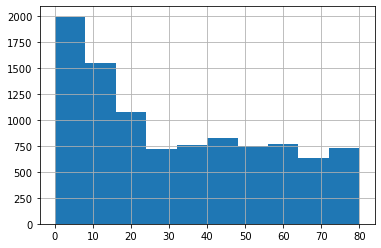

In [6]:
#Checking Age Distribution
cad_df.Age.hist();

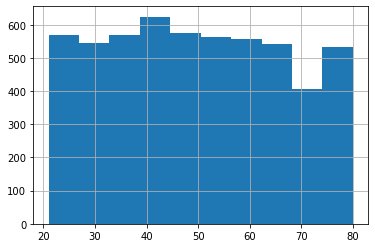

In [7]:
# Keeping individuals ages 21 and over. 
cad_df = cad_df[(cad_df.Age >= 21)]
cad_df.Age.hist();

In [8]:
cad_df.isna().sum()

SEQN             0
Age              0
Gender           0
HT              57
WT              54
BMI             67
Race             0
DBP_1          469
DBP_2          286
DBP_3          276
DBP_4         5092
SBP_1          469
SBP_2          286
SBP_3          276
SBP_4         5092
HR            5482
Pulse          180
Arrhythmia     179
HDL            237
LDL           3008
TC             237
TG            2968
Glu            251
FH_MI            0
DTS              5
Smoker        3076
Smoked_100       0
DM               0
MI               0
CAD              0
dtype: int64

In [9]:
#Obtaining average blood pressure
avg_sys_bp = cad_df[['SBP_1', 'SBP_2', 'SBP_3', 'SBP_4']].mean(axis=1).round(0)
avg_dia_bp = cad_df[['DBP_1', 'DBP_2', 'DBP_3', 'DBP_4']].mean(axis=1).round(0)


#Obtaining column with just the non-HDL cholesterol
non_hdl = cad_df['TC'] - cad_df['HDL']

#Dropping unnecesary columns
cad_df.drop(columns=['SBP_1', 'SBP_2', 'SBP_3', 'SBP_4', 'DBP_1', 'DBP_2', 'DBP_3', 
                       'DBP_4', 'HR', 'TC', 'TG', 'HDL', 'LDL', 'HT', 'WT', 'SEQN'], inplace=True)

#Inserting new columns at specified locations
cad_df.insert(7, 'SBP', avg_sys_bp)
cad_df.insert(8, 'DBP', avg_dia_bp)
cad_df.insert(12, 'Non_HDL', non_hdl)

cad_df.head()

,Age,Gender,BMI,Race,Pulse,Arrhythmia,Glu,SBP,DBP,FH_MI,DTS,Smoker,Non_HDL,Smoked_100,DM,MI,CAD
0,69.0,1.0,26.7,4.0,86.0,1.0,554.0,113.0,74.0,2.0,600.0,3.0,102.0,1.0,1.0,2.0,2.0
1,54.0,1.0,28.6,3.0,74.0,1.0,219.0,157.0,61.0,2.0,540.0,2.0,120.0,1.0,1.0,2.0,2.0
2,72.0,1.0,28.9,3.0,68.0,1.0,183.0,142.0,82.0,1.0,300.0,3.0,66.0,1.0,1.0,2.0,2.0
4,73.0,2.0,19.7,3.0,92.0,1.0,104.0,137.0,87.0,1.0,480.0,NaN,116.0,2.0,2.0,2.0,2.0
5,56.0,1.0,41.7,1.0,60.0,1.0,104.0,157.0,82.0,2.0,360.0,3.0,188.0,1.0,2.0,1.0,1.0


In [10]:
cad_df.CAD.value_counts()

2.0    5243
1.0     224
9.0      15
Name: CAD, dtype: int64

In [11]:
# Droping all columns with code 9.0:"Not Sure"
index9 = cad_df[(cad_df.DM == 9.0) | (cad_df.MI == 9.0) | (cad_df.CAD == 9.0) | (cad_df.FH_MI == 9.0)].index

cad_df.drop(index9, inplace=True)
cad_df.CAD.value_counts(dropna=False)

2.0    5113
1.0     215
Name: CAD, dtype: int64

In [12]:
#Function that changes all desired categorical data to a binary 1 and 0.
def binaryinator(category_list):
    
    #Loop for categorical variable list
    for cat in category_list:

        # All variables not = 1.0 "present" will change to 0.0 "not present",
        cad_df[cat].mask((cad_df[cat] != 1.0), 0.0, inplace=True)

In [13]:
#Change categorical data to binary data of 1 and 0 (other than race)

#Category variable list to enter into function.
category_list=['CAD', 'MI', 'DM', 'Gender', 'FH_MI']

#Function for binary categories
binaryinator(category_list)

#Other variables that need to be changed following other criteria

#Changing Arrhythmia code 1.0 "Regular Heartbeat" to 0.0.
cad_df.Arrhythmia.mask((cad_df.Arrhythmia == 1.0), 0.0, inplace=True)

#Changing Arrhythmia code 2.0 "Irregular Heartbeat" to 1.0.
cad_df.Arrhythmia.mask((cad_df.Arrhythmia == 2.0), 1.0, inplace=True)

#Combining codes 1.0 and 2.0 from the "Smoker" column which are "Smokes Everyday" and "Smokes Some Days" to "Smoker" code of 1.0
cad_df.Smoker.mask((cad_df['Smoker']== 2.0), 1.0, inplace=True)

#Changing code 3.0 "Smokes Not At All" to "Non-Smoker" code of 0.0
cad_df.Smoker.mask((cad_df['Smoker']== 3.0), 0.0, inplace=True)

cad_df.head()

,Age,Gender,BMI,Race,Pulse,Arrhythmia,Glu,SBP,DBP,FH_MI,DTS,Smoker,Non_HDL,Smoked_100,DM,MI,CAD
0,69.0,1.0,26.7,4.0,86.0,0.0,554.0,113.0,74.0,0.0,600.0,0.0,102.0,1.0,1.0,0.0,0.0
1,54.0,1.0,28.6,3.0,74.0,0.0,219.0,157.0,61.0,0.0,540.0,1.0,120.0,1.0,1.0,0.0,0.0
2,72.0,1.0,28.9,3.0,68.0,0.0,183.0,142.0,82.0,1.0,300.0,0.0,66.0,1.0,1.0,0.0,0.0
4,73.0,0.0,19.7,3.0,92.0,0.0,104.0,137.0,87.0,1.0,480.0,NaN,116.0,2.0,0.0,0.0,0.0
5,56.0,1.0,41.7,1.0,60.0,0.0,104.0,157.0,82.0,0.0,360.0,0.0,188.0,1.0,0.0,1.0,1.0


In [14]:
cad_df.isna().sum()

Age              0
Gender           0
BMI             60
Race             0
Pulse          169
Arrhythmia     168
Glu            240
SBP            179
DBP            179
FH_MI            0
DTS              5
Smoker        3000
Non_HDL        226
Smoked_100       0
DM               0
MI               0
CAD              0
dtype: int64

In [15]:
def cad_mean_imputer(var_list):
    
    #for loop to loop through list of variables to be imputed
    for var in var_list:
        
        #Filters for imputing mean values based on gender and presence of CAD
        male_CAD =  (cad_df.CAD == 1.0) & (cad_df.Gender == 1.0)
        male_noCAD = (cad_df.CAD == 0.0) & (cad_df.Gender == 1.0)
        female_CAD =  (cad_df.CAD == 1.0) & (cad_df.Gender == 0.0)
        female_noCAD = (cad_df.CAD == 0.0) & (cad_df.Gender == 0.0)
        
        #Determine mean values using above filters
        avg_male_CAD = cad_df[male_CAD][var].mean().round(1)
        avg_male_noCAD = cad_df[male_noCAD][var].mean().round(1)
        avg_female_CAD = cad_df[female_CAD][var].mean().round(1)
        avg_female_noCAD = cad_df[female_noCAD][var].mean().round(1)
        
        #Impute mean vales
        cad_df[var].mask(male_CAD & (cad_df[var].isna()), avg_male_CAD, inplace=True)
        cad_df[var].mask(male_noCAD & (cad_df[var].isna()), avg_male_noCAD, inplace=True)
        cad_df[var].mask(female_CAD & (cad_df[var].isna()), avg_female_CAD, inplace=True)
        cad_df[var].mask(female_noCAD & (cad_df[var].isna()), avg_female_noCAD, inplace=True)

In [16]:
# list of variables to impute 
var_list = ['BMI', 'SBP', 'DBP', 'Pulse', 'Glu', 'Non_HDL', 'DTS']

# Imputer function
cad_mean_imputer(var_list)

# Check number of null values
cad_df.isna().sum()

Age              0
Gender           0
BMI              0
Race             0
Pulse            0
Arrhythmia     168
Glu              0
SBP              0
DBP              0
FH_MI            0
DTS              0
Smoker        3000
Non_HDL          0
Smoked_100       0
DM               0
MI               0
CAD              0
dtype: int64

In [17]:
# imputing "Non-Smoker" (code 0.0) for null values in the "Smoker" column by using the "Smoked_100" column 
# for individuals who reported smoking less than 100 cigarettes in there lifetime.
cad_df.Smoker.mask((cad_df['Smoker'].isna()) & (cad_df['Smoked_100'] == 2.0), 0.0, inplace=True, axis=0)

#Dropping "Smoked_100" column
cad_df.drop(columns=['Smoked_100'], inplace=True)

In [18]:
cad_df.isna().sum()

Age             0
Gender          0
BMI             0
Race            0
Pulse           0
Arrhythmia    168
Glu             0
SBP             0
DBP             0
FH_MI           0
DTS             0
Smoker          2
Non_HDL         0
DM              0
MI              0
CAD             0
dtype: int64

In [19]:
# imputing remaining two nulls as "non-smoker"
cad_df.Smoker = cad_df.Smoker.fillna(0.0)

In [20]:
#Imputing null Values for Arrythmia column as 0.0
cad_df.Arrhythmia = cad_df.Arrhythmia.fillna(0.0)

In [21]:
cad_df.isna().sum()

Age           0
Gender        0
BMI           0
Race          0
Pulse         0
Arrhythmia    0
Glu           0
SBP           0
DBP           0
FH_MI         0
DTS           0
Smoker        0
Non_HDL       0
DM            0
MI            0
CAD           0
dtype: int64

In [22]:
# Convert Data types back to integers for categorical variables
int_columns = {'Age': int,
               'Gender': int,
               'Race': int,
               'Arrhythmia': int,
              'FH_MI': int,
              'Smoker': int,
              'DM': int,
               'MI': int,
              'CAD': int}
cad_df = cad_df.astype(int_columns)
cad_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5328 entries, 0 to 9810
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Age         5328 non-null   int32  
 1   Gender      5328 non-null   int32  
 2   BMI         5328 non-null   float64
 3   Race        5328 non-null   int32  
 4   Pulse       5328 non-null   float64
 5   Arrhythmia  5328 non-null   int32  
 6   Glu         5328 non-null   float64
 7   SBP         5328 non-null   float64
 8   DBP         5328 non-null   float64
 9   FH_MI       5328 non-null   int32  
 10  DTS         5328 non-null   float64
 11  Smoker      5328 non-null   int32  
 12  Non_HDL     5328 non-null   float64
 13  DM          5328 non-null   int32  
 14  MI          5328 non-null   int32  
 15  CAD         5328 non-null   int32  
dtypes: float64(7), int32(9)
memory usage: 520.3 KB


In [23]:
#Encoding race categories to binary categories
cad_df = pd.get_dummies(cad_df, columns=(['Race']))
cad_df.head()

,Age,Gender,BMI,Pulse,Arrhythmia,Glu,SBP,DBP,FH_MI,DTS,Smoker,Non_HDL,DM,MI,CAD,Race_1,Race_2,Race_3,Race_4,Race_5
0,69,1,26.7,86.0,0,554.0,113.0,74.0,0,600.0,0,102.0,1,0,0,0,0,0,1,0
1,54,1,28.6,74.0,0,219.0,157.0,61.0,0,540.0,1,120.0,1,0,0,0,0,1,0,0
2,72,1,28.9,68.0,0,183.0,142.0,82.0,1,300.0,0,66.0,1,0,0,0,0,1,0,0
4,73,0,19.7,92.0,0,104.0,137.0,87.0,1,480.0,0,116.0,0,0,0,0,0,1,0,0
5,56,1,41.7,60.0,0,104.0,157.0,82.0,0,360.0,0,188.0,0,1,1,1,0,0,0,0


In [24]:
# Define Target Variable
y = cad_df.CAD

# Drop Target Variable From Data
X = cad_df.drop(columns=('CAD'))
X.head()

,Age,Gender,BMI,Pulse,Arrhythmia,Glu,SBP,DBP,FH_MI,DTS,Smoker,Non_HDL,DM,MI,Race_1,Race_2,Race_3,Race_4,Race_5
0,69,1,26.7,86.0,0,554.0,113.0,74.0,0,600.0,0,102.0,1,0,0,0,0,1,0
1,54,1,28.6,74.0,0,219.0,157.0,61.0,0,540.0,1,120.0,1,0,0,0,1,0,0
2,72,1,28.9,68.0,0,183.0,142.0,82.0,1,300.0,0,66.0,1,0,0,0,1,0,0
4,73,0,19.7,92.0,0,104.0,137.0,87.0,1,480.0,0,116.0,0,0,0,0,1,0,0
5,56,1,41.7,60.0,0,104.0,157.0,82.0,0,360.0,0,188.0,0,1,1,0,0,0,0


In [25]:
#Split Data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

#Balance data using the Synthetic Minority Oversampling Technique(SMOTE)
smote = SMOTE()
X_train_smote, y_train_smote,  = smote.fit_resample(X_train, y_train)

#View changes due to smote
print(f'Minority Class before smote: {y_train.value_counts().iloc[1]}')
print(f'Majority Class before smote: {y_train.value_counts().iloc[0]}')
print(f'Minority Class after smote: {y_train_smote.value_counts().iloc[1]}')
print(f'Majority Class after smote: {y_train_smote.value_counts().iloc[0]}')

Minority Class before smote: 171
Majority Class before smote: 3825
Minority Class after smote: 3825
Majority Class after smote: 3825


In [26]:
# Store ML Classifiers to be compared into variables
dt_clf = DecisionTreeClassifier()
rf_clf = RandomForestClassifier()
xgb_clf = XGBClassifier()

In [27]:
#Function to automatically fits the model, makes predictions on the test data and evaluates the models performance.
def cad_clf(classifier):
    model = classifier
    model.fit(X_train_smote, y_train_smote)
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train_smote)
    acc_train = accuracy_score(y_train_smote, y_train_pred)*100
    acc_test = accuracy_score(y_test, y_test_pred)*100
    f2_train = fbeta_score(y_train_smote, y_train_pred, beta=2.0)*100
    f2_test = fbeta_score(y_test, y_test_pred, beta=2.0)*100
    cm = confusion_matrix(y_test, y_test_pred)
    print(f'''Accuracy of Predictions on Training Data: {round(acc_train, 2)}
Accuracy of Predictions on Test Data: {round(acc_test, 2)}
                                 ''')
    print(f'''F2 Score for Training Data: {round(f2_train, 2)}
F2 Score for Test Data: {round(f2_test, 2)}
                    ''')
    print('Confusion Matrix Numbers for Test Data')
    print(' ')
    print(f'''True Negatives: {cm[0][0]}
False Negatives: {cm[1][0]}
False Positives: {cm[0][1]}
True Positives: {cm[1][1]}
 ''')
    cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    cm_disp.plot()
    plt.title(f'Confusion Matrix')
    plt.show()

In [28]:
#Function that takes in a classifie dictionary with the names as keys and classifiers as values to compare classifiers
def cad_clf_compare(clf_dict):
    classifiers = clf_dict
    for i in range(len(clf_dict)):
        print('---------------------------')
        print(list(clf_dict.keys())[i])
        print('---------------------------')
        cad_clf(list(clf_dict.values())[i])

---------------------------
Decision Tree Classifier
---------------------------
Accuracy of Predictions on Training Data: 100.0
Accuracy of Predictions on Test Data: 90.02
                                 
F2 Score for Training Data: 100.0
F2 Score for Test Data: 26.94
                    
Confusion Matrix Numbers for Test Data
 
True Negatives: 1183
False Negatives: 28
False Positives: 105
True Positives: 16
 


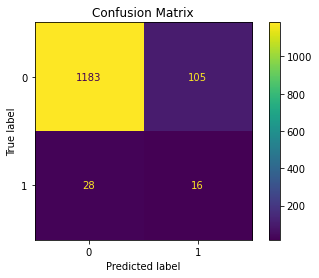

---------------------------
Random Forest Classifier
---------------------------
Accuracy of Predictions on Training Data: 100.0
Accuracy of Predictions on Test Data: 94.07
                                 
F2 Score for Training Data: 100.0
F2 Score for Test Data: 25.53
                    
Confusion Matrix Numbers for Test Data
 
True Negatives: 1241
False Negatives: 32
False Positives: 47
True Positives: 12
 


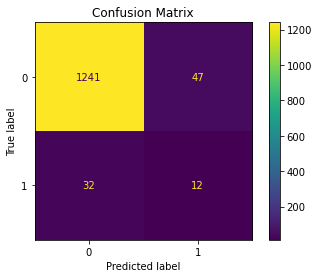

---------------------------
XGBoost Classifier
---------------------------
Accuracy of Predictions on Training Data: 99.99
Accuracy of Predictions on Test Data: 95.95
                                 
F2 Score for Training Data: 99.98
F2 Score for Test Data: 32.71
                    
Confusion Matrix Numbers for Test Data
 
True Negatives: 1264
False Negatives: 30
False Positives: 24
True Positives: 14
 


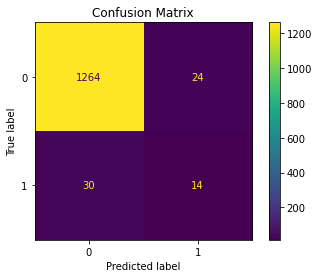

In [29]:
#Classifier Dictionary
clf_dict = {'Decision Tree Classifier': DecisionTreeClassifier(), 'Random Forest Classifier': RandomForestClassifier(), 'XGBoost Classifier': XGBClassifier()}

#Compare classifiers using function
cad_clf_compare(clf_dict)

In [30]:
#Function to take in model and display the feature importances.
def ftr_imp(model):
    n_features = X_train_smote.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train_smote.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')
    plt.show()

In [31]:
#function that takes dictionary of models and compares them best on their feature importances.
def ftr_imp_comp(clf_dict):
    for i in range(len(clf_dict)):
        print(f'                          {list(clf_dict.keys())[i]}')
        ftr_imp(list(clf_dict.values())[i])
        print('''          ----------------------------------------------------------
        ''');

                          Decision Tree Classifier


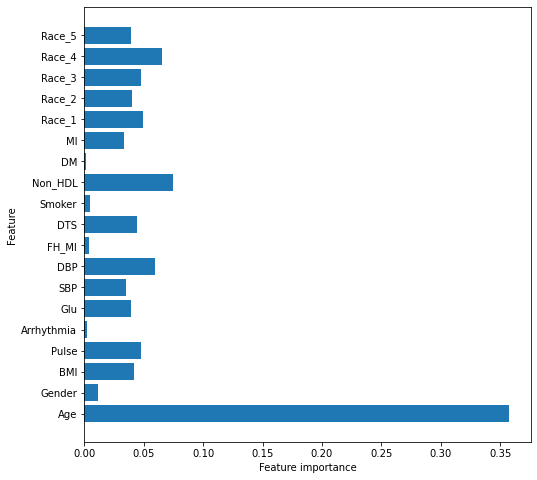

          ----------------------------------------------------------
        
                          Random Forest Classifier


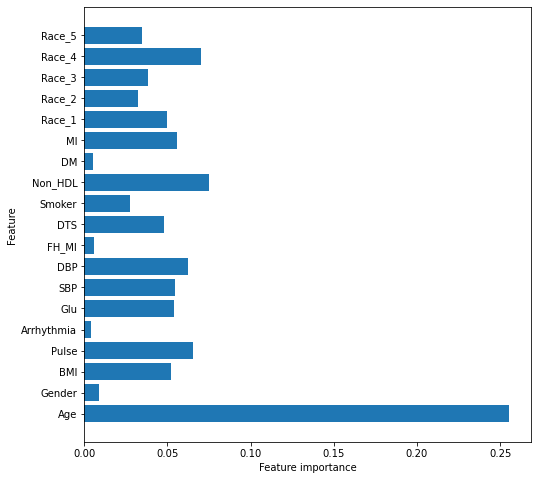

          ----------------------------------------------------------
        
                          XGBoost Classifier


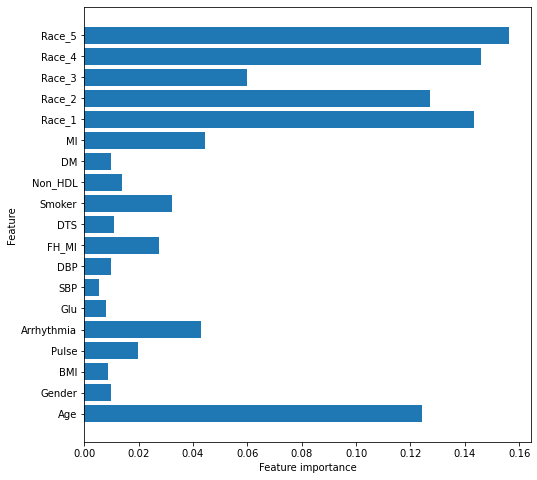

          ----------------------------------------------------------
        


In [32]:
#Use ftr_imp_comp model to compare feature importances of the three classifiers
ftr_imp_comp(clf_dict)

---------------------------
Decision Tree Classifier
---------------------------
Accuracy of Predictions on Training Data: 100.0
Accuracy of Predictions on Test Data: 90.24
                                 
F2 Score for Training Data: 100.0
F2 Score for Test Data: 28.72
                    
Confusion Matrix Numbers for Test Data
 
True Negatives: 1185
False Negatives: 27
False Positives: 103
True Positives: 17
 


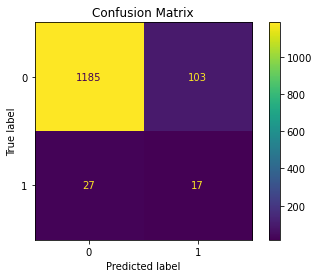

---------------------------
Random Forest Classifier
---------------------------
Accuracy of Predictions on Training Data: 100.0
Accuracy of Predictions on Test Data: 94.67
                                 
F2 Score for Training Data: 100.0
F2 Score for Test Data: 37.66
                    
Confusion Matrix Numbers for Test Data
 
True Negatives: 1243
False Negatives: 26
False Positives: 45
True Positives: 18
 


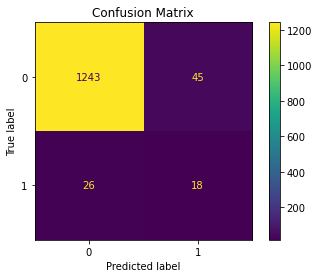

---------------------------
XGBoost Classifier
---------------------------
Accuracy of Predictions on Training Data: 99.99
Accuracy of Predictions on Test Data: 95.95
                                 
F2 Score for Training Data: 99.98
F2 Score for Test Data: 38.64
                    
Confusion Matrix Numbers for Test Data
 
True Negatives: 1261
False Negatives: 27
False Positives: 27
True Positives: 17
 


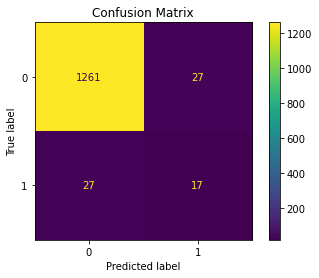

In [33]:
#Test Model Performance based on new features

#drop columns based on feature importances results
cad_df.drop(columns=(['DM', 'FH_MI', 'Arrhythmia', 'Gender']), inplace=True)

# Define Target Variable
y = cad_df.CAD

# Drop Target Variable From Data
X = cad_df.drop(columns=('CAD'))

#Split Data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

#Balance data using the Synthetic Minority Oversampling Technique(SMOTE)
smote = SMOTE()
X_train_smote, y_train_smote,  = smote.fit_resample(X_train, y_train)

#Use function to compare models based on new features
cad_clf_compare(clf_dict)

In [35]:
#Perform a RandomizedSearchCV to find more optimal Hyperparameters Tuning

#Make an f2 scorer to perform a randomizedSearchCV for hyperparameter tuning
f2_scorer = make_scorer(fbeta_score, beta=2, greater_is_better = True)

#define parameter criteria for RandomizedSearch CV
param_grid = { 
    'criterion': ['gini', 'entropy'],
    'n_estimators': range(50,150,25),
    'max_depth': range(2,20,2),
    'max_features': ['sqrt', 'log2'],
    'min_samples_leaf': range(1,10,1),
    'min_samples_split': range(2,10,1)
}

rf_rs_f2 = RandomizedSearchCV(estimator=RandomForestClassifier(),
                 param_distributions=param_grid,
                 n_iter=25,
                 scoring=f2_scorer,
                 random_state=42)

# Perform the hyperparameter tuning with random search
rf_rs_f2.fit(X_train_smote, y_train_smote)

# List best parameter findings
rf_rs_f2.best_params_

{'n_estimators': 100,
 'min_samples_split': 8,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 16,
 'criterion': 'entropy'}

Accuracy of Predictions on Training Data: 98.58
Accuracy of Predictions on Test Data: 93.24
                                 
F2 Score for Training Data: 98.95
F2 Score for Test Data: 44.44
                    
Confusion Matrix Numbers for Test Data
 
True Negatives: 1218
False Negatives: 20
False Positives: 70
True Positives: 24
 


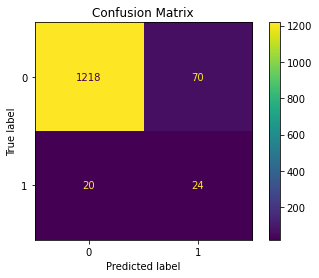

In [37]:
#Define a classifier with the best parameters found in RandomizedSearchCV these parameters
rf_hyp_opt = RandomForestClassifier(n_estimators=100, min_samples_split= 8, min_samples_leaf= 2, max_features='sqrt', max_depth=16, criterion='entropy')

#Use training Function to fit and test new model.
cad_clf(rf_hyp_opt)